In [2]:
# Importer les bibliothèques nécessaires
import numpy as np
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import os
from glob import glob

In [3]:
# Charger ResNet50 sans la couche de classification
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [4]:


def extract_features(img, model):
    # Redimensionner l'image à 224x224 pixels
    img = img.resize((224, 224))
    # Convertir l'image en un tableau numpy
    x = image.img_to_array(img)
    # Ajouter une dimension (pour représenter le batch de 1 image)
    x = np.expand_dims(x, axis=0)
    # Prétraiter l'image pour ResNet
    x = preprocess_input(x)
    # Passer l'image dans le modèle pour extraire les features
    features = model.predict(x)
    # Aplatir le vecteur de sortie (c'est déjà un vecteur de 2048, donc facultatif ici)
    return features.flatten()


On réalise 2 fonctions de découpage d'images, une pour les caméras du haut où le ciel prédomine et l'autre pour les caméras du bas où la mer prédomine. Le but est, pour les 2 groupes d'images, d'isoler un rectangle de ciel (resp de mer) pour que le clustering se fasse exclusivement en fonction de l'état du ciel (resp de la mer). Le but sera de mettre ces fonctions dans un fichier .py réalisé par Timothée pour pouvoir les appeler

In [5]:
from PIL import Image

#Fonction qui découpe un rectangle dans le ciel

from PIL import Image

def decoupe_rectangle_ciel(image):
    # Dimensions du rectangle à découper
    crop_width = 1561
    crop_height = 780

    # Calculer les coordonnées du rectangle à découper
    width, height = image.size
    left = (width - crop_width) / 2
    top = 0
    right = left + crop_width
    bottom = top + crop_height

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image



In [6]:
from PIL import Image

#Fonction qui découpe un rectangle dans la mer

def decoupe_rectangle_mer(image):
    # Dimensions du carré à découper
    crop_size = 820
    offset = 126

    # Calculer les coordonnées du carré à découper au centre de l'image avec décalage à droite
    width, height = image.size
    left = (width - crop_size) / 2 + offset
    top = (height - crop_size) / 2
    right = left + crop_size
    bottom = top + crop_size

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image




 # Adapatation de l'algorithme initial de resNet 50

Il s'agit ici de reprendre l'algorithme initiallement utilisé pour extraire les features des images grâce à ResNet50. Cependant, on ajoute une modification, en fonction du titre de l'image (qui contient le numero de frame) on classe l'image dans une des 2 listes photos_ciel et photos_mer. On peut ensuite appliquer les 2 fonctions ci-dessus pour extraire un rectangle de l'image pour chacune des 2 listes en créant ainsi 2 nouvelles listes: extraits_photos_ciel et extraits_photos_mer. On applique ResNet50 à ces 2 listes

In [11]:
import glob
import numpy as np
import os
from PIL import Image

# Initialiser les listes pour stocker les photos
photos_ciel = []
photos_mer = []

# Listes pour les images découpées
photos_ciel_découpés = []
photos_mer_découpés = []

# Listes pour stocker les features
features_ciel_list = []
features_mer_list = []

# Chemin vers le dossier d'images
dossier_images = "/Users/gariperez/Desktop/IMT ATLANTIQUE/2A/Projet commande entreprise/DATASET_SENSEA/images/"

# Chemin vers les sous-dossiers photos_ciel et photos_mer
photos_ciel_path = os.path.join(dossier_images, "photos_ciel")
photos_mer_path = os.path.join(dossier_images, "photos_mer")

# Paramètres pour réduire le nombre d'images traitées
N = 100  # Traiter une image sur N pour réduire le temps d'exécution

# Liste des images dans chaque dossier
photos_ciel = glob.glob(os.path.join(photos_ciel_path, "*.jpg"))
photos_mer = glob.glob(os.path.join(photos_mer_path, "*.jpg"))

# Afficher la taille des listes photos_ciel et photos_mer
print(f"Nombre d'images dans photos_ciel: {len(photos_ciel)}")
print(f"Nombre d'images dans photos_mer: {len(photos_mer)}")

# Paramétrer un filtrage pour limiter les images traitées (1 image sur N)
photos_ciel_filtered = photos_ciel[::N]
photos_mer_filtered = photos_mer[::N]

# Afficher la taille après filtrage
print(f"Nombre d'images filtrées pour photos_ciel: {len(photos_ciel_filtered)}")
print(f"Nombre d'images filtrées pour photos_mer: {len(photos_mer_filtered)}")

# Découper les images du ciel
for img_path in photos_ciel_filtered:
    with Image.open(img_path) as img:
        extrait_ciel = decoupe_rectangle_ciel(img)  
        photos_ciel_découpés.append(extrait_ciel)

# Afficher la taille de la liste des images découpées pour le ciel
print(f"Nombre d'images découpées pour photos_ciel: {len(photos_ciel_découpés)}")

# Découper les images de la mer
for img_path in photos_mer_filtered:
    with Image.open(img_path) as img:
        extrait_mer = decoupe_rectangle_mer(img)  
        photos_mer_découpés.append(extrait_mer)

# Afficher la taille de la liste des images découpées pour la mer
print(f"Nombre d'images découpées pour photos_mer: {len(photos_mer_découpés)}")

# Extraire les features des images découpées pour le ciel
for img in photos_ciel_découpés:
    features_ciel = extract_features(img, model)  

# Afficher la taille de la liste des features pour le ciel
print(f"Nombre de features extraites pour photos_ciel: {len(features_ciel_list)}")

# Extraire les features des images découpées pour la mer
for img in photos_mer_découpés:
    features_mer = extract_features(img, model)  
    features_mer_list.append(features_mer)

# Afficher la taille de la liste des features pour la mer
print(f"Nombre de features extraites pour photos_mer: {len(features_mer_list)}")

# Convertir les listes de features en tableaux numpy
features_ciel_array = np.array(features_ciel_list)
features_mer_array = np.array(features_mer_list)

# Afficher la forme des tableaux numpy
print(f"Shape of features_ciel_array: {features_ciel_array.shape}")
print(f"Shape of features_mer_array: {features_mer_array.shape}")


Nombre d'images dans photos_ciel: 9829
Nombre d'images dans photos_mer: 9611
Nombre d'images filtrées pour photos_ciel: 99
Nombre d'images filtrées pour photos_mer: 97
Nombre d'images découpées pour photos_ciel: 99
Nombre d'images découpées pour photos_mer: 97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━

In [12]:
# Vérifier la forme des données avant d'appliquer PCA
print("Shape of features_ciel_array before PCA:", features_ciel_array.shape)
print("Shape of features_mer_array before PCA:", features_mer_array.shape)

Shape of features_ciel_array before PCA: (99, 2048)
Shape of features_mer_array before PCA: (97, 2048)


In [14]:
from sklearn.decomposition import PCA

# Supposons que `features_array` soit le tableau de features de 2048 dimensions (chaque ligne est un vecteur de features pour une image)
# Vérifions sa taille pour être sûr
print(features_ciel_array.shape)  # Par exemple, (num_images, 2048)
print(features_mer_array.shape)  

# On applique PCA pour réduire à un nombre de dimensions réduit, ici 50 pour l'exemple
pca = PCA(n_components=50)
reduced_features_ciel = pca.fit_transform(features_ciel_array)
reduced_features_mer = pca.fit_transform(features_mer_array)



# Affichage des dimensions après réduction
print(reduced_features_mer.shape)  # Par exemple, (num_images, 50)
print(reduced_features_ciel.shape) 

(99, 2048)
(97, 2048)
(97, 50)
(99, 50)


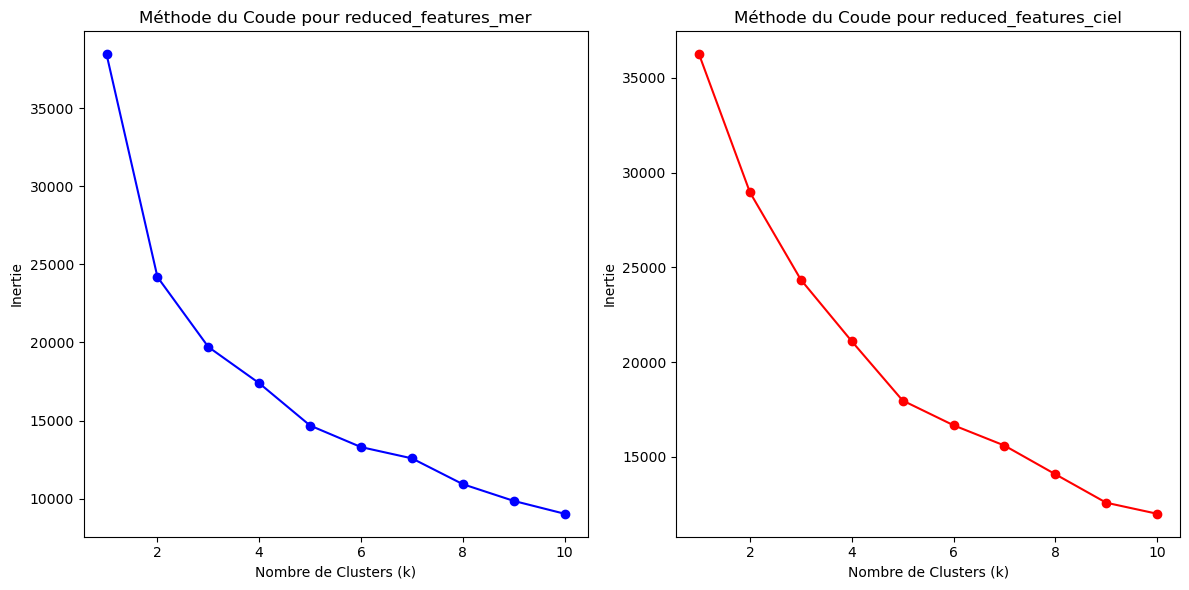

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Liste pour stocker les inerties
inertias_mer = []
inertias_ciel = []

# Tester K-means pour différents nombres de clusters (de 1 à 10)
for k in range(1, 11):
    # Appliquer KMeans sur reduced_features_mer
    kmeans_mer = KMeans(n_clusters=k, random_state=0)
    kmeans_mer.fit(reduced_features_mer)  # Utilisez reduced_features_mer pour la mer
    inertias_mer.append(kmeans_mer.inertia_)

    # Appliquer KMeans sur reduced_features_ciel
    kmeans_ciel = KMeans(n_clusters=k, random_state=0)
    kmeans_ciel.fit(reduced_features_ciel)  # Utilisez reduced_features_ciel pour le ciel
    inertias_ciel.append(kmeans_ciel.inertia_)

# Tracer le graphique de la méthode du coude pour reduced_features_mer
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Premier graphique
plt.plot(range(1, 11), inertias_mer, marker='o', color='b')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_mer')

# Tracer le graphique de la méthode du coude pour reduced_features_ciel
plt.subplot(1, 2, 2)  # Deuxième graphique
plt.plot(range(1, 11), inertias_ciel, marker='o', color='r')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_ciel')

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [16]:
from sklearn.cluster import KMeans

# Choisir le nombre optimal de clusters (exemple avec k=5)
k_optimal = 5

# Appliquer K-means pour reduced_features_mer
kmeans_mer = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_mer = kmeans_mer.fit_predict(reduced_features_mer)  # Appliquer K-Means sur reduced_features_mer

# Afficher les étiquettes des clusters pour chaque image de reduced_features_mer
print("Étiquettes des clusters pour reduced_features_mer:")
print(labels_kmeans_mer)

# Appliquer K-means pour reduced_features_ciel
kmeans_ciel = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_ciel = kmeans_ciel.fit_predict(reduced_features_ciel)  # Appliquer K-Means sur reduced_features_ciel

# Afficher les étiquettes des clusters pour chaque image de reduced_features_ciel
print("Étiquettes des clusters pour reduced_features_ciel:")
print(labels_kmeans_ciel)


Étiquettes des clusters pour reduced_features_mer:
[4 4 0 4 1 4 4 4 0 4 4 4 4 0 4 2 0 4 0 4 0 4 2 4 0 4 0 4 2 0 0 2 0 0 4 2 0
 4 4 2 3 2 0 3 1 0 1 2 4 4 4 1 4 0 2 3 2 4 1 0 2 4 4 2 4 2 2 4 0 0 4 0 4 0
 1 4 4 4 4 4 1 4 1 4 2 4 1 4 2 4 2 4 0 0 4 0 4]
Étiquettes des clusters pour reduced_features_ciel:
[2 4 2 0 4 4 0 3 4 3 3 3 2 3 3 3 3 3 3 4 4 4 3 3 4 4 2 0 3 1 4 2 0 3 2 4 1
 3 3 2 2 0 1 0 4 3 0 0 3 4 3 3 0 2 0 2 2 4 0 3 0 0 0 3 1 0 0 3 2 3 4 1 4 4
 0 1 0 4 4 1 2 4 0 3 2 4 0 4 2 3 0 0 2 1 2 3 4 3 4]


In [24]:
def afficher_photos_aleatoires(images, labels_kmeans, num_photos=50):
    indices = np.random.choice(len(images), num_photos, replace=False)
    nb_colonnes = 10
    nb_lignes = num_photos // nb_colonnes + (num_photos % nb_colonnes > 0)

    plt.figure(figsize=(15, nb_lignes * 1.5))

    for i, idx in enumerate(indices):
        plt.subplot(nb_lignes, nb_colonnes, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Cluster {labels_kmeans[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


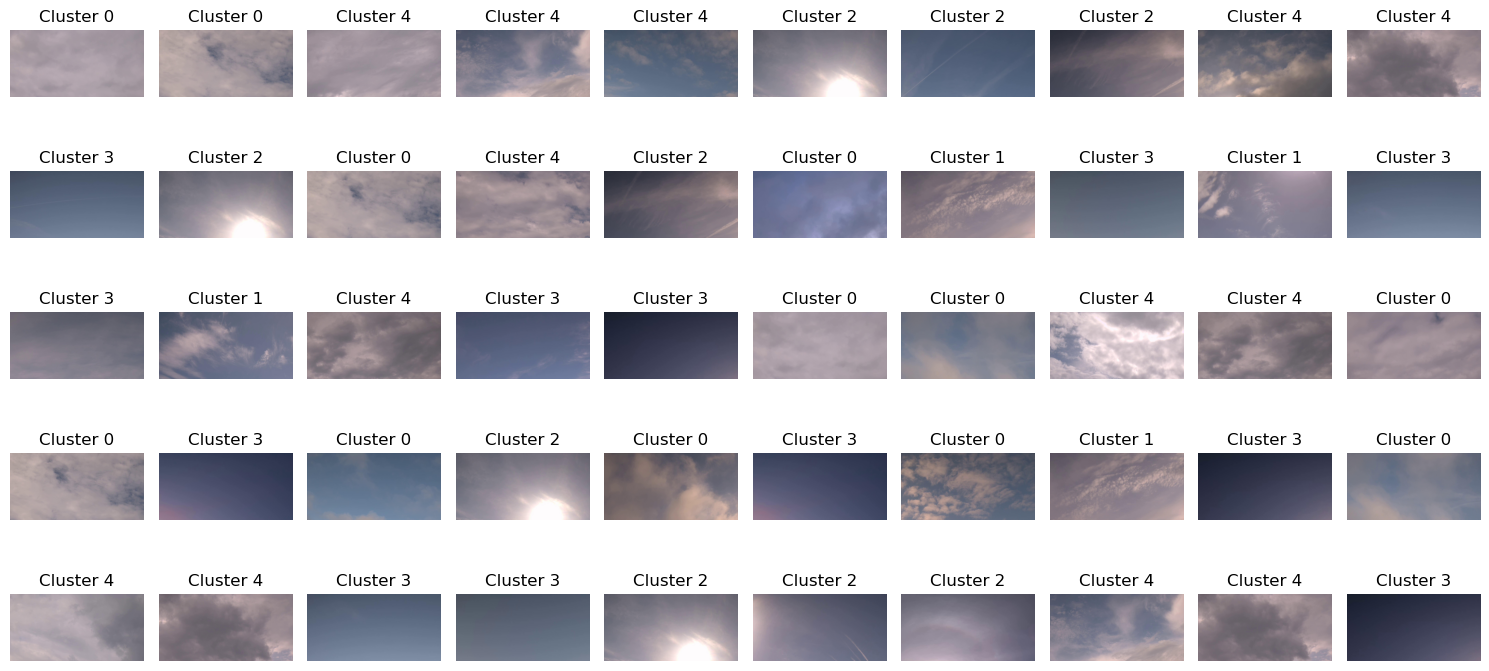

In [26]:
afficher_photos_aleatoires(photos_ciel_découpés, labels_kmeans_ciel, num_photos=50)

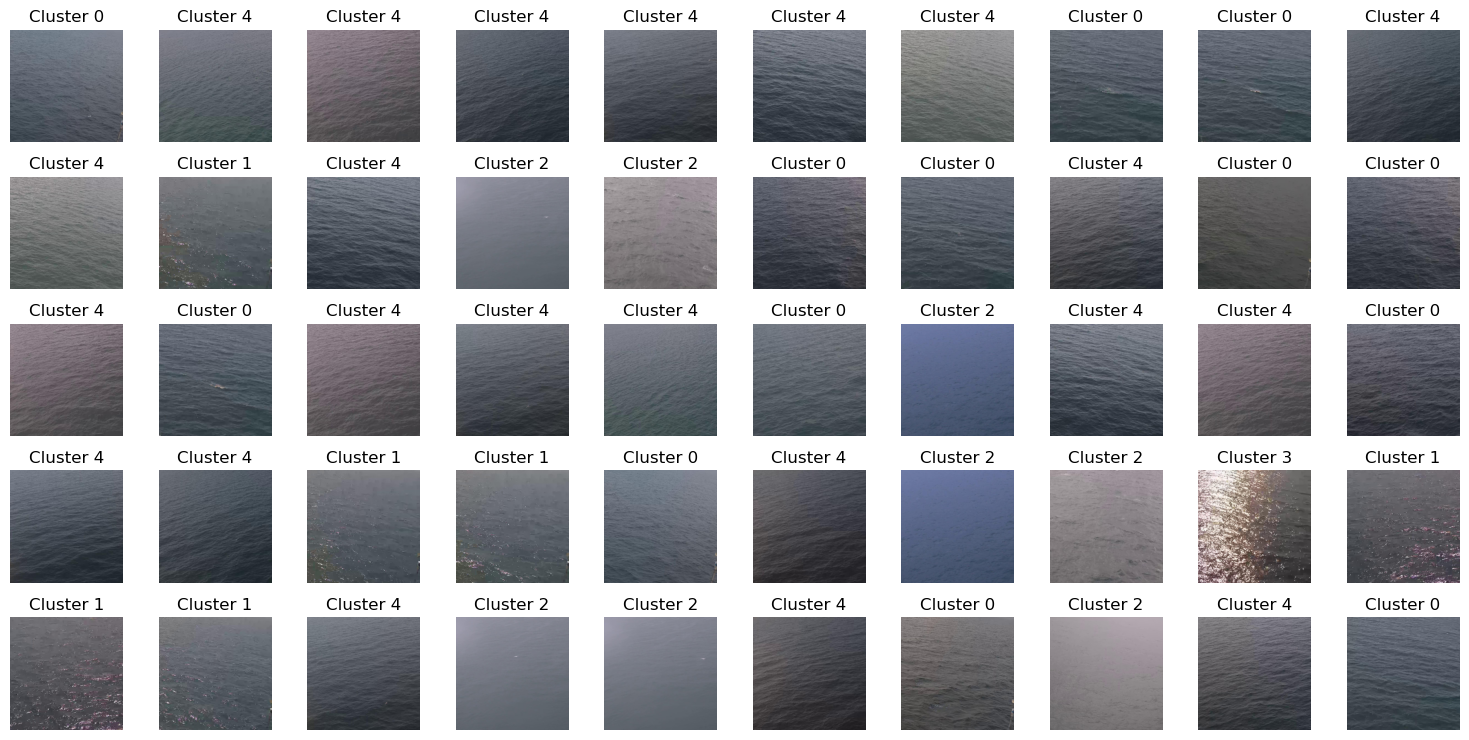

In [27]:
afficher_photos_aleatoires(photos_mer_découpés, labels_kmeans_mer, num_photos=50)